# Mean Field Algorithm for DBMs

In [1]:
import numpy as np
import pdb
import pickle as pkl
import matplotlib
%matplotlib inline
#matplotlib.use('agg')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tqdm import tqdm
import argparse
import sys
import os

/home/chahuja/env/th/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
## Set random state to reproduce data
rState = np.random.RandomState(212)
# Load Data
train = np.matrix(np.genfromtxt('digitstrain.txt', delimiter=','))
rState.shuffle(train) ## Shuffle to improve convergence
test = np.matrix(np.genfromtxt('digitstest.txt', delimiter=','))
val = np.matrix(np.genfromtxt('digitsvalid.txt', delimiter=','))

# Removing the class from the dataset

_train = train[:,:-1]
_test = test[:,:-1]
_val = val[:,:-1]

# and thresholding to {0,1}
train = np.round(_train)
test = np.round(_test)
val = np.round(_val)

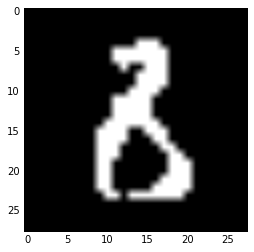

In [3]:
# Plotting the image 
## The data is in row-major format
def plot_image(train):
  plt.imshow(train[0].reshape((28,28)), cmap=plt.cm.gray)
## The image is squeezed row-wise
plot_image(train)

In [4]:
def softplus(X):
  return np.log(1+np.exp(X))

def sigmoid(mat):
  return 1./(1+ np.exp(-mat))

def cross_entropy_loss(vec, gt):
  ## take the average
  return (-np.multiply(gt,np.log(vec)) - np.multiply(1-gt,np.log(1-vec))).sum()/vec.shape[1]

def copy_list(a):
  return [a[i].copy() for i in range(len(a))]

# Visualization

In [5]:
## Visualizing filters
def vis(W, save_name):
  dim = W.shape[1]
  n_image_rows = int(np.ceil(np.sqrt(dim)))
  n_image_cols = int(np.ceil(dim * 1.0/n_image_rows))
  gs = gridspec.GridSpec(n_image_rows,n_image_cols,top=1., bottom=0., right=1., left=0., hspace=0., wspace=0.)
  for g,count in zip(gs,range(int(dim))):
    ax = plt.subplot(g)
    ax.imshow(W[:,count].reshape((28,28)))
    ax.set_xticks([])
    ax.set_yticks([])
  plt.savefig(save_name + '_vis.png')

def plot_cce(model, save_name):  
  train_plt = plt.plot(range(len(model.hist.train_loss)),model.hist.train_loss, 'r--', label='Train')
  val_plt = plt.plot(range(len(model.hist.val_loss)),model.hist.val_loss, 'g-', label="Val")
  plt.xlabel('No. of Epochs')
  plt.ylabel('mean(Entropy Loss)')
  plt.savefig(save_name+'.png')

def plot_err(model, save_name):  
  train_plt = plt.plot(range(len(model.hist.train_loss)),model.hist.train_class_loss, 'r--', label='Train')
  val_plt = plt.plot(range(len(model.hist.val_loss)),model.hist.val_class_loss, 'g-', label="Val")
  plt.xlabel('No. of Epochs')
  plt.ylabel('Classification Error')
  plt.savefig(save_name+'_err.png')

# Saving and loading the model

In [65]:
def save_model(model, filename):
  fl = open(filename,'wb')
  pkl.dump(model,fl)
  
def save_weights(model, filename):
  fl = open(filename, 'wb')
  pkl.dump([model.W1, model.W2, model.b, model.c, model.d], fl)
  
def load_model(filename):
  fl = open(filename, 'rb')
  return pkl.load(fl)

# Loss History Class

In [66]:
class history(object):
  def __init__(self):
    self.train_loss = list()
    self.val_loss = list()
    
  def add(self,train_loss, val_loss):
    self.train_loss.append(train_loss)
    self.val_loss.append(val_loss)

# Model Class DBM

In [173]:
class DBM(object):
  def __init__(self,graph,batch,chains):
    self.graph = graph
    self.hist = history()
    self.chains = chains
    self.batch = batch
    
    ## initialize the weights
    high = np.sqrt(6.0/(sum(graph[:-1])))
    low = -high
    self.W1 = rState.uniform(low=low,high=high, size=(graph[0],graph[1])) # VXH1
    self.W2 = rState.uniform(low=low,high=high, size=(graph[1],graph[2])) # H1XH2
    self.b = rState.uniform(low=low,high=high, size=(graph[0],1)) # VX1
    self.c = rState.uniform(low=low,high=high, size=(graph[1],1)) # H1X1
    self.d = rState.uniform(low=low,high=high, size=(graph[2],1)) # H2X1
    ## E(v,h1,h2) = -v'W1h1 -h1'W2v - b'v - c'h1 - d'h2 
    
    self.randomize_gibbs_updates()
    self.W_optimal = copy_list([self.W1, self.W2, self.b, self.c, self.d])

  def randomize_gibbs_updates(self):
    self.V_tilda = self.sample(rState.uniform(low=0,high=1, size=(self.chains,self.graph[0])))
    self.H1_tilda = self.sample(rState.uniform(low=0,high=1, size=(self.chains,self.graph[1])))
    self.H2_tilda = self.sample(rState.uniform(low=0,high=1, size=(self.chains,self.graph[2])))
    
  def restore_optimal_weights(self):
    self.W1 = self.W_optimal[0]
    self.W2 = self.W_optimal[1]
    self.b = self.W_optimal[2]
    self.c = self.W_optimal[3]
    self.d = self.W_optimal[4]

  def h(self,x):
    return sigmoid(np.matmul(self.W, x) + self.b)
  
  def h_inv(self, h):
    return sigmoid(np.matmul(self.W.T, h) + self.c)
  
  def h1_v_h2(self,v,h2):
    return sigmoid(np.matmul(v, self.W1) + np.matmul(h2, self.W2.T)+ self.c.T)
  
  def v_h1(self, h1):
    return sigmoid(np.matmul(h1, self.W1.T) + self.b.T)
  
  def h2_h1(self, h1):
    return sigmoid(np.matmul(h1, self.W2) + self.d.T)
    
  def sample(self,P):
    return np.random.binomial(1,P,size=P.shape)
  
  ## Mean field updates
  def mfu(self,V):
    self.H1_cap = self.sample(rState.uniform(low=0,high=1, size=(self.batch,self.graph[1])))
    self.H2_cap = self.sample(rState.uniform(low=0,high=1, size=(self.batch,self.graph[2])))
    
    #pdb.set_trace()
    self.H1_cap = sigmoid(np.matmul(V,self.W1) + np.matmul(self.H2_cap, self.W2.T) + self.c.T)
    self.H2_cap = sigmoid(np.matmul(self.H1_cap,self.W2) + self.d.T)
    
  ## MCMC chain to predict a {0,1} output
  def MCMC(self, k):
    ## create a MCMC chain
    for i in range(k):
      _v = sigmoid(np.matmul(self.H1_tilda, self.W1.T) + self.b.T) 
      self.V_tilda = self.sample(_v)
      
      _h2 = sigmoid(np.matmul(self.H1_tilda, self.W2) + self.d.T)
      self.H2_tilda = self.sample(_h2)
      
      _h1 = sigmoid(np.matmul(self.V_tilda, self.W1) + np.matmul(self.H2_tilda, self.W2.T)+ self.c.T)
      self.H1_tilda = self.sample(_h1)
  
  ## MCMC chain to predict a continous output
  def generation(self, x, k):
    _x = self.sample(x)
    _x = _x.T
    _h2 = self.sample(rState.uniform(low=0,high=1,size=(x.shape[1],self.graph[2])))
    for i in tqdm(range(k)):
      _h1 = self.sample(self.h1_v_h2(_x,_h2))
      _h2 = self.sample(self.h2_h1(_h1))
      _h1 = self.sample(self.h1_v_h2(_x,_h2))
      _x = self.sample(self.v_h1(_h1))
    
    return _x.T
  
  def train(self, V, k=1, lr=0.01):
    self.mfu(V)
    self.MCMC(k)
    gradW1 = np.matmul(V.T, self.H1_cap/(self.batch*1.0)) - np.matmul(self.V_tilda.T, self.H1_tilda/(self.chains*1.0)) 
    gradW2 = np.matmul(self.H1_cap.T, self.H2_cap/(self.batch*1.0)) - np.matmul(self.H1_tilda.T, self.H2_tilda/(self.chains*1.0)) 
    gradb = np.mean(V,axis=0) - np.mean(self.V_tilda, axis=0)
    gradc = np.mean(self.H1_cap,axis=0) - np.mean(self.H1_tilda, axis=0)
    gradd = np.mean(self.H2_cap,axis=0) - np.mean(self.H2_tilda, axis=0)
    
    ## gradient updates applied on the weights
    self.W1 += lr*gradW1
    self.W2 += lr*gradW2
    self.b += lr*gradb.T
    self.c += lr*gradc.T
    self.d += lr*gradd.T

In [174]:
def mean_cross_entropy_loss(model, X, k=1):
  x_gt = X
  _x = model.sample(x_gt)
  _h2 = model.sample(rState.uniform(low=0,high=1,size=(X.shape[0],model.graph[2])))
  for _ in range(k):
    _x = model.sample(_x)
    _h1 = model.sample(model.h1_v_h2(_x,_h2))
    _h2 = model.sample(model.h2_h1(_h1))
    _h1 = model.sample(model.h1_v_h2(_x,_h2))
    _x = model.v_h1(_h1)
    #x_cap = model.h_inv(model.sample(model.h(model.sample(x_gt))))
  l = cross_entropy_loss(_x.T, x_gt.T)
  return l

In [175]:
def sgd_train(args):
  ## automatically creating a savename
  save_name = "%s_k%d_graph_%d" %(args.save_dir, args.num_mcmc,args.graph[1])
  save_name = os.path.join(args.save_dir, save_name)
  
  ## initilizing the rbm model
  dbm = DBM(args.graph,args.batch, args.chains)
  if args.batch > len(train):
    args.batch = len(train)
  indices = range(0,len(train)+1, args.batch)
  for count in tqdm(range(args.num_epochs)):
    for start,end in zip(indices[:-1], indices[1:]):
      dbm.train(train[start:end,:], k=args.num_mcmc, lr=args.lr)
    ## Calculation of cross entropy loss
    train_loss = mean_cross_entropy_loss(dbm, train)
    val_loss = mean_cross_entropy_loss(dbm, val)
    ## Add loss to the history variable
    dbm.hist.add(train_loss, val_loss)
    tqdm.write("Epochs:%d TrainLoss:%5f ValLoss:%5f" % (count, train_loss, val_loss))
    
  ## plot and save images
  plot_cce(model=dbm, save_name=save_name)
  vis(W=dbm.W1, save_name=save_name)
  
  ## save model
  save_model(dbm, save_name + '_model.p')
  ## save weights
  save_weights(dbm, save_name + 'weights.p')
  return dbm

In [176]:
def digit_generation(model, filename='temp'):
  X = np.random.uniform(size=train[0:100].T.shape)
  ## binarize the input
  X = np.round(X)
  print np.max(X), np.min(X)
  X_cap = model.generation(X,1000)
  vis(X_cap,filename+'_gen')

In [177]:
def main():
  parser = argparse.ArgumentParser()
  parser.add_argument('--save_dir', type=str, default='save',
                      help='directory to store checkpointed models')
  parser.add_argument('--graph', type=int ,nargs='+', default=[784,100,100],
                      help='Structure of the NN') 
  parser.add_argument('--batch', type=int , default=10,
                      help='mini-batch size') 
  parser.add_argument('--chains', type=int , default=100,
                      help='number of chains') 
  parser.add_argument('--lam', type=float, default=0,
                      help='regularizing coefficient')
  parser.add_argument('--lr', type=float, default=0.01,
                      help='learning rate')
  parser.add_argument('--num_epochs', type=int, default=1, 
                      help='number of epochs')
  parser.add_argument('--num_mcmc', type=int, default=1, 
                      help='number of mcmc iterations')
  parser.add_argument('--seed', type=int, default=212, 
                      help='Random Seed')
  args = parser.parse_args()
  try:
    os.makedirs(args.save_dir)
  except:
    pass
  ## Train model
  model = sgd_train(args)
  
  ## (c) Sample from images
  save_name = "%s_k%d_graph_%d" %(args.save_dir, args.num_mcmc,args.graph[1])
  save_name = os.path.join(args.save_dir, save_name)
  digit_generation(model, filename=save_name)
  return model

  1%|          | 1/100 [00:02<04:21,  2.64s/it]

Epochs:0 TrainLoss:220.541814 ValLoss:220.824476
Epochs:1 TrainLoss:209.345391 ValLoss:209.632140

  2%|▏         | 2/100 [00:05<04:14,  2.60s/it]


Epochs:2 TrainLoss:204.086190 ValLoss:204.193833

  3%|▎         | 3/100 [00:07<04:16,  2.64s/it]


Epochs:3 TrainLoss:204.196459 ValLoss:204.082474

  4%|▍         | 4/100 [00:10<04:10,  2.61s/it]


Epochs:4 TrainLoss:203.410547 ValLoss:203.453790

  5%|▌         | 5/100 [00:12<03:58,  2.52s/it]


Epochs:5 TrainLoss:201.071080 ValLoss:201.134408

  6%|▌         | 6/100 [00:14<03:45,  2.40s/it]


Epochs:6 TrainLoss:199.450632 ValLoss:199.674910

  7%|▋         | 7/100 [00:17<03:46,  2.44s/it]


Epochs:7 TrainLoss:199.350859 ValLoss:199.527303

  8%|▊         | 8/100 [00:19<03:42,  2.42s/it]


Epochs:8 TrainLoss:199.516809 ValLoss:199.841832

  9%|▉         | 9/100 [00:22<03:50,  2.53s/it]


Epochs:9 TrainLoss:197.943413 ValLoss:198.377277

 10%|█         | 10/100 [00:24<03:44,  2.50s/it]


Epochs:10 TrainLoss:193.500606 ValLoss:193.880153

 11%|█         | 11/100 [00:27<03:40,  2.48s/it]


Epochs:11 TrainLoss:191.798305 ValLoss:192.161218

 12%|█▏        | 12/100 [00:29<03:40,  2.50s/it]


Epochs:12 TrainLoss:190.622268 ValLoss:190.850147

 13%|█▎        | 13/100 [00:32<03:43,  2.56s/it]


Epochs:13 TrainLoss:187.671386 ValLoss:188.134441

 14%|█▍        | 14/100 [00:35<03:41,  2.58s/it]


Epochs:14 TrainLoss:186.020421 ValLoss:186.498069

 15%|█▌        | 15/100 [00:37<03:33,  2.52s/it]


Epochs:15 TrainLoss:185.923043 ValLoss:186.658780

 16%|█▌        | 16/100 [00:40<03:30,  2.50s/it]


Epochs:16 TrainLoss:182.395677 ValLoss:182.919571

 17%|█▋        | 17/100 [00:42<03:22,  2.44s/it]


Epochs:17 TrainLoss:181.148829 ValLoss:181.791168

 18%|█▊        | 18/100 [00:45<03:23,  2.49s/it]


Epochs:18 TrainLoss:180.312679 ValLoss:181.153309

 19%|█▉        | 19/100 [00:47<03:23,  2.51s/it]


Epochs:19 TrainLoss:177.318204 ValLoss:177.849753

 20%|██        | 20/100 [00:49<03:15,  2.45s/it]


Epochs:20 TrainLoss:176.182576 ValLoss:176.739917

 21%|██        | 21/100 [00:52<03:07,  2.37s/it]


Epochs:21 TrainLoss:176.443741 ValLoss:177.149187

 22%|██▏       | 22/100 [00:54<03:11,  2.46s/it]


Epochs:22 TrainLoss:173.256776 ValLoss:174.008530

 23%|██▎       | 23/100 [00:57<03:15,  2.54s/it]


Epochs:23 TrainLoss:171.837548 ValLoss:172.713984

 24%|██▍       | 24/100 [00:59<03:11,  2.52s/it]


Epochs:24 TrainLoss:170.603435 ValLoss:171.500353

 25%|██▌       | 25/100 [01:02<03:20,  2.67s/it]


Epochs:25 TrainLoss:169.218973 ValLoss:170.087830

 26%|██▌       | 26/100 [01:05<03:22,  2.73s/it]


Epochs:26 TrainLoss:168.037436 ValLoss:169.040255

 27%|██▋       | 27/100 [01:08<03:25,  2.81s/it]


Epochs:27 TrainLoss:166.834188 ValLoss:167.865858

 28%|██▊       | 28/100 [01:11<03:18,  2.76s/it]


Epochs:28 TrainLoss:165.624392 ValLoss:166.749632

 29%|██▉       | 29/100 [01:13<03:10,  2.68s/it]


Epochs:29 TrainLoss:164.507673 ValLoss:165.422305

 30%|███       | 30/100 [01:16<03:10,  2.72s/it]


Epochs:30 TrainLoss:163.618865 ValLoss:164.660257

 31%|███       | 31/100 [01:19<03:06,  2.71s/it]


Epochs:31 TrainLoss:162.606751 ValLoss:163.815939

 32%|███▏      | 32/100 [01:22<03:03,  2.69s/it]


Epochs:32 TrainLoss:161.757859 ValLoss:162.875672

 33%|███▎      | 33/100 [01:24<03:03,  2.73s/it]


Epochs:33 TrainLoss:160.768892 ValLoss:162.114830

 34%|███▍      | 34/100 [01:27<02:58,  2.70s/it]


Epochs:34 TrainLoss:160.149277 ValLoss:161.389780

 35%|███▌      | 35/100 [01:30<02:52,  2.66s/it]


Epochs:35 TrainLoss:159.234707 ValLoss:160.466159

 36%|███▌      | 36/100 [01:32<02:53,  2.72s/it]


Epochs:36 TrainLoss:158.566355 ValLoss:159.816452

 37%|███▋      | 37/100 [01:35<02:49,  2.70s/it]


Epochs:37 TrainLoss:157.894559 ValLoss:159.283024

 38%|███▊      | 38/100 [01:37<02:38,  2.56s/it]


Epochs:38 TrainLoss:157.013774 ValLoss:158.385079

 39%|███▉      | 39/100 [01:40<02:37,  2.57s/it]


Epochs:39 TrainLoss:156.422295 ValLoss:157.784120

 40%|████      | 40/100 [01:42<02:32,  2.55s/it]


Epochs:40 TrainLoss:155.754211 ValLoss:157.389875

 41%|████      | 41/100 [01:45<02:21,  2.40s/it]


Epochs:41 TrainLoss:155.438125 ValLoss:156.861428

 42%|████▏     | 42/100 [01:47<02:21,  2.43s/it]


Epochs:42 TrainLoss:154.772065 ValLoss:156.375128

 43%|████▎     | 43/100 [01:50<02:22,  2.50s/it]


Epochs:43 TrainLoss:154.302050 ValLoss:155.808909

 44%|████▍     | 44/100 [01:52<02:23,  2.55s/it]


Epochs:44 TrainLoss:153.722112 ValLoss:155.306442

 45%|████▌     | 45/100 [01:55<02:20,  2.55s/it]


Epochs:45 TrainLoss:153.304215 ValLoss:155.013585

 46%|████▌     | 46/100 [01:58<02:21,  2.62s/it]


Epochs:46 TrainLoss:152.802437 ValLoss:154.379982

 47%|████▋     | 47/100 [02:00<02:19,  2.63s/it]


Epochs:47 TrainLoss:152.259912 ValLoss:153.971009

 48%|████▊     | 48/100 [02:03<02:16,  2.62s/it]


Epochs:48 TrainLoss:151.811290 ValLoss:153.389563

 49%|████▉     | 49/100 [02:05<02:10,  2.57s/it]


Epochs:49 TrainLoss:151.219578 ValLoss:152.868005

 50%|█████     | 50/100 [02:08<02:06,  2.53s/it]


Epochs:50 TrainLoss:150.669559 ValLoss:152.493432

 51%|█████     | 51/100 [02:10<02:05,  2.57s/it]


Epochs:51 TrainLoss:150.358278 ValLoss:152.013586

 52%|█████▏    | 52/100 [02:13<02:03,  2.57s/it]


Epochs:52 TrainLoss:150.034109 ValLoss:151.739116

 53%|█████▎    | 53/100 [02:16<01:59,  2.54s/it]


Epochs:53 TrainLoss:149.516930 ValLoss:151.097744

 54%|█████▍    | 54/100 [02:18<01:56,  2.53s/it]


Epochs:54 TrainLoss:149.120480 ValLoss:150.949694

 55%|█████▌    | 55/100 [02:21<02:01,  2.71s/it]


Epochs:55 TrainLoss:148.785829 ValLoss:150.515863

 56%|█████▌    | 56/100 [02:24<02:00,  2.73s/it]


Epochs:56 TrainLoss:148.402217 ValLoss:150.148596

 57%|█████▋    | 57/100 [02:27<01:56,  2.72s/it]


Epochs:57 TrainLoss:148.124409 ValLoss:149.731421

 58%|█████▊    | 58/100 [02:29<01:49,  2.60s/it]


Epochs:58 TrainLoss:147.768179 ValLoss:149.446250

 59%|█████▉    | 59/100 [02:32<01:47,  2.61s/it]


Epochs:59 TrainLoss:147.369738 ValLoss:149.051664

 60%|██████    | 60/100 [02:34<01:45,  2.64s/it]


Epochs:60 TrainLoss:146.983623 ValLoss:148.685189

 61%|██████    | 61/100 [02:37<01:43,  2.64s/it]


Epochs:61 TrainLoss:146.627284 ValLoss:148.396969

 62%|██████▏   | 62/100 [02:39<01:38,  2.58s/it]


Epochs:62 TrainLoss:146.263723 ValLoss:148.065304

 63%|██████▎   | 63/100 [02:42<01:36,  2.60s/it]


Epochs:63 TrainLoss:146.065130 ValLoss:147.842762

 64%|██████▍   | 64/100 [02:44<01:29,  2.49s/it]


Epochs:64 TrainLoss:145.693906 ValLoss:147.528392

 65%|██████▌   | 65/100 [02:47<01:29,  2.55s/it]


Epochs:65 TrainLoss:145.506646 ValLoss:147.271394

 66%|██████▌   | 66/100 [02:50<01:29,  2.63s/it]


Epochs:66 TrainLoss:145.020886 ValLoss:146.868129

 67%|██████▋   | 67/100 [02:52<01:24,  2.55s/it]


Epochs:67 TrainLoss:144.708308 ValLoss:146.505689

 68%|██████▊   | 68/100 [02:54<01:17,  2.41s/it]


Epochs:68 TrainLoss:144.405075 ValLoss:146.584302

 69%|██████▉   | 69/100 [02:57<01:15,  2.43s/it]


Epochs:69 TrainLoss:144.127109 ValLoss:145.984726

 70%|███████   | 70/100 [02:59<01:11,  2.37s/it]


Epochs:70 TrainLoss:143.883953 ValLoss:145.885920

 71%|███████   | 71/100 [03:01<01:10,  2.43s/it]


Epochs:71 TrainLoss:143.595522 ValLoss:145.567250

 72%|███████▏  | 72/100 [03:04<01:08,  2.46s/it]


Epochs:72 TrainLoss:143.294074 ValLoss:145.333252

 73%|███████▎  | 73/100 [03:07<01:07,  2.50s/it]


Epochs:73 TrainLoss:142.976585 ValLoss:144.831580

 74%|███████▍  | 74/100 [03:09<01:05,  2.53s/it]


Epochs:74 TrainLoss:142.840265 ValLoss:144.777583

 75%|███████▌  | 75/100 [03:12<01:02,  2.52s/it]


Epochs:75 TrainLoss:142.433635 ValLoss:144.398689

 76%|███████▌  | 76/100 [03:14<00:59,  2.49s/it]


Epochs:76 TrainLoss:142.376379 ValLoss:144.234340

 77%|███████▋  | 77/100 [03:17<00:56,  2.47s/it]


Epochs:77 TrainLoss:142.045319 ValLoss:144.056365

 78%|███████▊  | 78/100 [03:19<00:54,  2.47s/it]


Epochs:78 TrainLoss:141.655963 ValLoss:143.670826

 79%|███████▉  | 79/100 [03:21<00:51,  2.46s/it]


Epochs:79 TrainLoss:141.510593 ValLoss:143.501520

 80%|████████  | 80/100 [03:24<00:49,  2.48s/it]


Epochs:80 TrainLoss:141.137320 ValLoss:143.094501

 81%|████████  | 81/100 [03:26<00:46,  2.45s/it]


Epochs:81 TrainLoss:140.856066 ValLoss:142.937286

 82%|████████▏ | 82/100 [03:29<00:43,  2.42s/it]


Epochs:82 TrainLoss:140.674532 ValLoss:142.808629

 83%|████████▎ | 83/100 [03:31<00:39,  2.34s/it]


Epochs:83 TrainLoss:140.536546 ValLoss:142.466925

 84%|████████▍ | 84/100 [03:33<00:37,  2.35s/it]


Epochs:84 TrainLoss:140.327491 ValLoss:142.373181

 85%|████████▌ | 85/100 [03:35<00:34,  2.31s/it]


Epochs:85 TrainLoss:140.024388 ValLoss:142.139218

 86%|████████▌ | 86/100 [03:38<00:32,  2.35s/it]


Epochs:86 TrainLoss:139.701764 ValLoss:141.874368

 87%|████████▋ | 87/100 [03:41<00:32,  2.49s/it]


Epochs:87 TrainLoss:139.575597 ValLoss:141.786696

 88%|████████▊ | 88/100 [03:43<00:29,  2.46s/it]


Epochs:88 TrainLoss:139.331539 ValLoss:141.410332

 89%|████████▉ | 89/100 [03:46<00:27,  2.52s/it]


Epochs:89 TrainLoss:139.134262 ValLoss:141.137301

 90%|█████████ | 90/100 [03:48<00:24,  2.45s/it]


Epochs:90 TrainLoss:138.975733 ValLoss:141.071809

 91%|█████████ | 91/100 [03:51<00:22,  2.48s/it]


Epochs:91 TrainLoss:138.816804 ValLoss:140.702656

 92%|█████████▏| 92/100 [03:53<00:20,  2.51s/it]


Epochs:92 TrainLoss:138.612229 ValLoss:140.641163

 93%|█████████▎| 93/100 [03:56<00:17,  2.47s/it]


Epochs:93 TrainLoss:138.329047 ValLoss:140.418301

 94%|█████████▍| 94/100 [03:58<00:14,  2.41s/it]


Epochs:94 TrainLoss:138.075779 ValLoss:140.204322

 95%|█████████▌| 95/100 [04:00<00:11,  2.39s/it]


Epochs:95 TrainLoss:137.834082 ValLoss:140.007362

 96%|█████████▌| 96/100 [04:03<00:09,  2.38s/it]


Epochs:96 TrainLoss:137.771807 ValLoss:139.832151

 97%|█████████▋| 97/100 [04:05<00:07,  2.46s/it]


Epochs:97 TrainLoss:137.457138 ValLoss:139.666879

 98%|█████████▊| 98/100 [04:08<00:04,  2.45s/it]


Epochs:98 TrainLoss:137.245477 ValLoss:139.278299

 99%|█████████▉| 99/100 [04:11<00:02,  2.58s/it]


Epochs:99 TrainLoss:136.984611 ValLoss:139.053174

100%|██████████| 100/100 [04:13<00:00,  2.60s/it]


1.0

 0.0
> <ipython-input-173-3352334173cd>(79)generation()
-> for i in tqdm(range(k)):
(Pdb) c


100%|██████████| 1000/1000 [00:34<00:00, 29.21it/s]


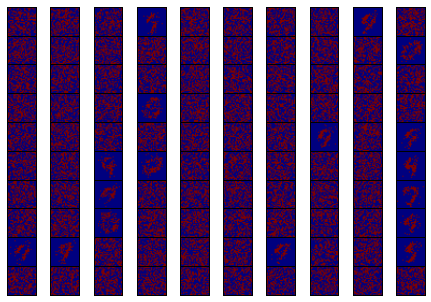

In [179]:
sys.argv=['train.py',
         '--save_dir','model',
         '--graph', '784', '100', '100',
         '--batch','100',
         '--chains','100',
         '--lr', '0.01',
         '--num_epochs', '100',
         '--num_mcmc', '1',
         '--seed', '212']
if __name__=="__main__":
  main()